In [50]:
import sys
sys.path.append("/Users/adi/School/Research/pipit")
import pipit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
trace1 = pipit.Trace.from_otf2("/Users/adi/Downloads/otf2_traces/tortuga-otf2-16/")
trace2 = pipit.Trace.from_otf2("/Users/adi/Downloads/otf2_traces/tortuga-otf2-32/")
trace3 = pipit.Trace.from_otf2("/Users/adi/Downloads/otf2_traces/tortuga-otf2-64/")
trace4 = pipit.Trace.from_otf2("/Users/adi/Downloads/otf2_traces/tortuga-otf2-128/")
trace5 = pipit.Trace.from_otf2("/Users/adi/Downloads/otf2_traces/tortuga-otf2-256/")

In [52]:
trace1.calc_exc_metrics()
trace2.calc_exc_metrics()
trace3.calc_exc_metrics()
trace4.calc_exc_metrics()
trace5.calc_exc_metrics()

In [53]:
fp1 = trace1.flat_profile()
fp2 = trace2.flat_profile()
fp3 = trace3.flat_profile()
fp4 = trace4.flat_profile()
fp5 = trace5.flat_profile()

In [54]:
combined_fp = pd.concat([fp1["time.exc"], fp2["time.exc"], fp3["time.exc"], fp4["time.exc"], fp5["time.exc"]], axis = 1).T
combined_fp.index = [16, 32, 64, 128, 256]
combined_fp.index.rename("Number of Processes", inplace = True)

In [55]:
combined_fp.drop(["MPI_Init", "writeSingleField"], axis = 1, inplace = True)

In [56]:
s = combined_fp.sum()
combined_fp = combined_fp[s.sort_values(ascending=False).index]

In [57]:
combined_fp

Name,computeRhs,gradC2C,MPI_Wait,setGhostCvsInterfaces,endGhostCvsInterfaces,MPI_Bcast,run,advanceTimestep_RK3,spectralRadius,MPI_Reduce,MPI_Isend,computeVelocityGradient,MPI_Irecv,MPI_Barrier,MPI_Allreduce,time-loop
Number of Processes,,,,,,,,,,,,,,,,
16,3.021824e+08,5.266552e+07,3.633939e+07,1.749993e+07,1.516629e+07,2.223580e+07,1.631792e+07,1.073275e+07,1.540317e+07,3.449538e+06,4.921698e+06,2.300964e+06,1.474385e+06,1.127440e+06,305174.805924,108849.770575
32,3.593897e+08,6.459017e+07,3.239433e+07,2.007468e+07,1.732592e+07,2.054251e+07,1.876178e+07,1.392044e+07,1.705465e+07,4.612167e+06,5.701082e+06,2.921724e+06,1.268819e+06,3.659647e+05,187252.709041,70491.896850
64,4.527277e+08,1.053937e+08,7.770124e+07,3.071575e+07,2.870159e+07,2.187696e+07,2.416414e+07,2.195970e+07,1.727128e+07,1.078930e+07,7.023484e+06,5.230773e+06,2.961271e+06,1.051799e+06,337845.564495,136012.578095
128,4.368499e+08,9.569441e+07,9.286200e+07,2.989702e+07,3.065985e+07,2.392863e+07,2.361672e+07,2.045853e+07,1.696519e+07,9.622369e+06,6.890914e+06,5.001051e+06,3.078582e+06,9.929060e+05,384206.052051,101277.665602
256,4.353201e+08,9.212073e+07,9.426601e+07,2.908435e+07,3.127370e+07,2.739652e+07,2.704699e+07,1.882587e+07,1.692384e+07,2.373934e+07,6.644304e+06,4.508243e+06,2.729943e+06,1.292455e+06,436932.791537,104188.373243


In [58]:
x = list(combined_fp.columns)

In [59]:
y = []
for i in range(len(x)):
    y.append(combined_fp[x[i]].to_list())

In [60]:
COOL = [
    "#4d8464",
    "#3e69b2",
    "#7fbe37",
    "#6899ce",
    "#4ac36b",
    "#56b5c7",
    "#52832f",
    "#72c19b",
    "#365525",
    "#97ba63",
]

# Hues restrained to "warm"
WARM = [
    "#ce98d7",
    "#db5036",
    "#9859ca",
    "#a94937",
    "#c849af",
    "#dc8e76",
    "#89578d",
    "#d03c73",
    "#975156",
    "#df809c",
]

In [61]:
def hex_to_rgb(hex):
    hex = hex.strip("#")

    r, g, b = int(hex[:2], 16), int(hex[2:4], 16), int(hex[4:], 16)
    return (r, g, b)

def rgb_to_hex(rgb):
    r, g, b = rgb
    return "#%02x%02x%02x" % (int(r), int(g), int(b))

def average_hex(*hex):
    """Averages any number of hex colors, returns result in hex"""
    colors = [hex_to_rgb(h) for h in hex]
    return rgb_to_hex(np.mean(colors, axis=0))

In [62]:
def get_palette(trace):
    # Idea: use cool for MPI, divide warm among non-MPIs
    functions = (
        trace.events[trace.events["Event Type"] == "Enter"]["Name"].unique().tolist()
    )

    mpi = sorted(list(filter(lambda x: x.startswith("MPI_"), functions)))
    nonmpi = sorted(list(set(functions).difference(mpi)))

    palette = {}
    cool = COOL.copy()
    warm = WARM.copy()

    # reserved colors
    palette["MPI"] = average_hex(*cool)

    palette["MPI_Init"] = cool.pop(len(cool) - 1)
    palette["MPI_Finalize"] = palette["MPI_Init"]

    palette["MPI_Send"] = cool.pop(0)
    palette["MPI_Isend"] = palette["MPI_Send"]

    palette["MPI_Recv"] = cool.pop(0)
    palette["MPI_Irecv"] = palette["MPI_Recv"]

    # assign remaining MPI functions based on index
    for i, f in enumerate(mpi):
        if f not in palette:
            palette[f] = cool[i % len(cool)]

    # assign remaining functions based on index
    for i, f in enumerate(nonmpi):
        if f not in palette:
            palette[f] = warm[i % len(warm)]

    return palette

In [63]:
colors = get_palette(trace1)

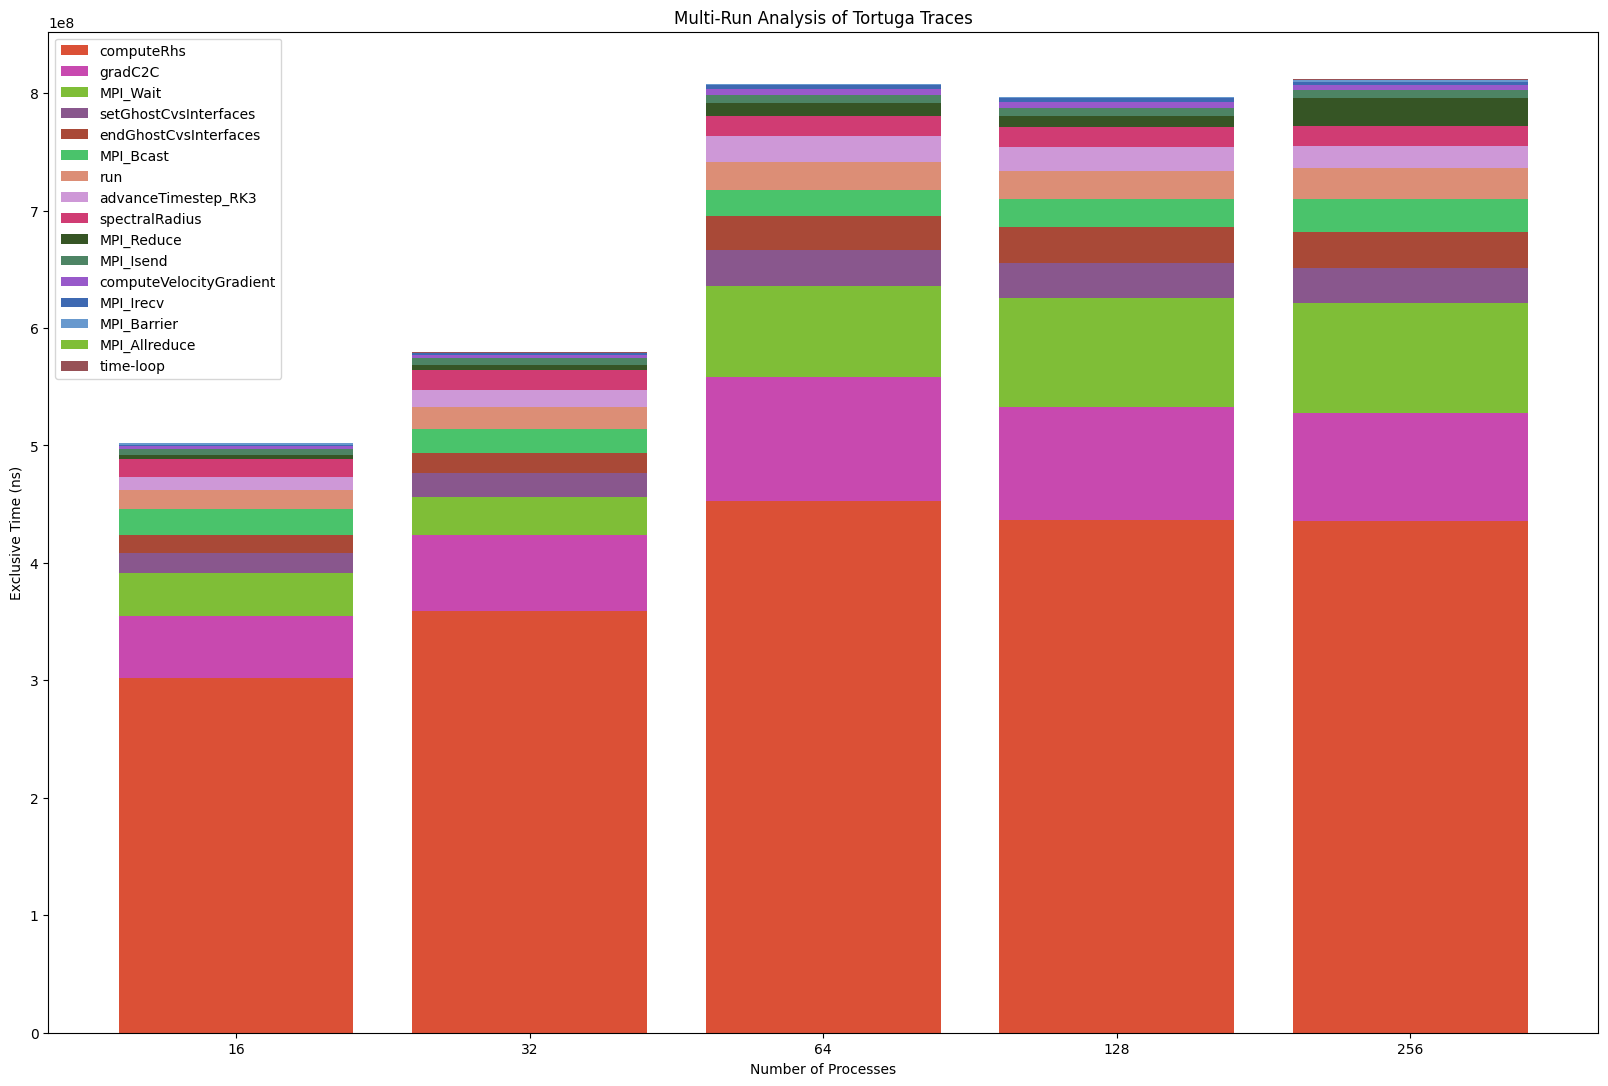

In [64]:
plt.rcParams["figure.figsize"] = (20, 13)

labels = ["16", "32", "64", "128", "256"]

for i in range(len(y)):
    if i == 0:
        plt.bar(labels, y[i], color = colors[x[i]])
    else:
        plt.bar(labels, y[i], bottom = np.sum(y[:i], axis = 0), color = colors[x[i]])

plt.xlabel("Number of Processes")
plt.ylabel("Exclusive Time (ns)")
plt.title("Multi-Run Analysis of Tortuga Traces")

plt.legend(x)
plt.show()